In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.4f}'.format

In [3]:

dfRaw = pd.read_csv("dataset.csv",index_col='DriverId')
dfRaw['ts']= pd.to_datetime(dfRaw.ts)
print('Size of dataset: {}'.format(len(dfRaw)))

Size of dataset: 899611


In [4]:
dfRaw.head(10)

,EventName,Latitude,Longitude,Speed km/h,ts
DriverId,,,,,
0,Timed Event,34.1866,-118.0881,64.0000,2017-11-01 00:00:02.430
0,Distance Event,34.1861,-118.0892,53.0000,2017-11-01 00:00:05.600
0,Distance Event,34.1864,-118.0896,34.0000,2017-11-01 00:00:13.640
0,Distance Event,34.1875,-118.0889,33.0000,2017-11-01 00:00:26.070
0,Distance Event,34.1887,-118.0865,32.0000,2017-11-01 00:00:35.090
0,Distance Event,34.1882,-118.0873,47.0000,2017-11-01 00:00:46.330
0,Distance Event,34.1894,-118.0864,24.0000,2017-11-01 00:00:55.320
0,Timed Event,34.1888,-118.0861,35.0000,2017-11-01 00:01:02.770
0,Distance Event,34.1891,-118.0851,43.0000,2017-11-01 00:01:06.610


In [5]:
maxTime = dfRaw['ts'].max()
minTime = dfRaw['ts'].min()
print("Events were taken between " + str(minTime.date()) + " and " + str(maxTime.date()))

Events were taken between 2017-10-31 and 2017-11-18


In [6]:
driverCount = len(dfRaw.index.value_counts())
print("Number of drivers: {}".format(driverCount))

Number of drivers: 89


In [8]:
eventsPerDriver = dfRaw.groupby('DriverId').agg({"EventName": "count"}).add_suffix('_count')
mean_events = np.mean(eventsPerDriver)
print("Mean number of events per driver {:0.1f}".format(mean_events))
eventsPerDriver.head(10)

Mean number of events per driver 10108.0


,EventName_count
DriverId,
0,17345
1,20694
2,11945
3,819
4,6811
5,24152
6,5700
7,12693
8,19606


Text(0, 0.5, 'Number of drivers')

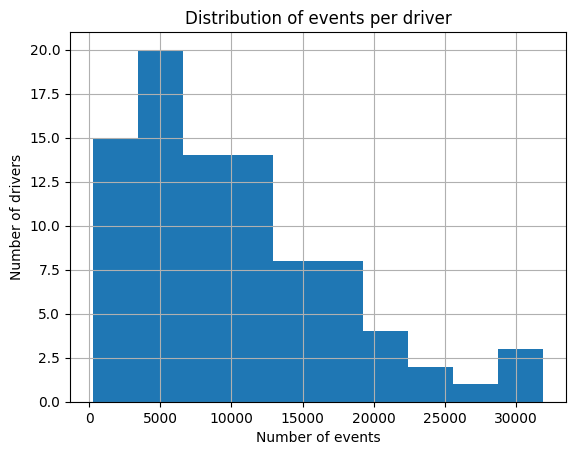

In [9]:
eventsPerDriver.sort_values(by='EventName_count',ascending = False,inplace = True)

eventsHist = eventsPerDriver['EventName_count'].hist()
eventsHist.set_title("Distribution of events per driver")
eventsHist.set_xlabel("Number of events")
eventsHist.set_ylabel("Number of drivers")

<Axes: ylabel='EventName'>

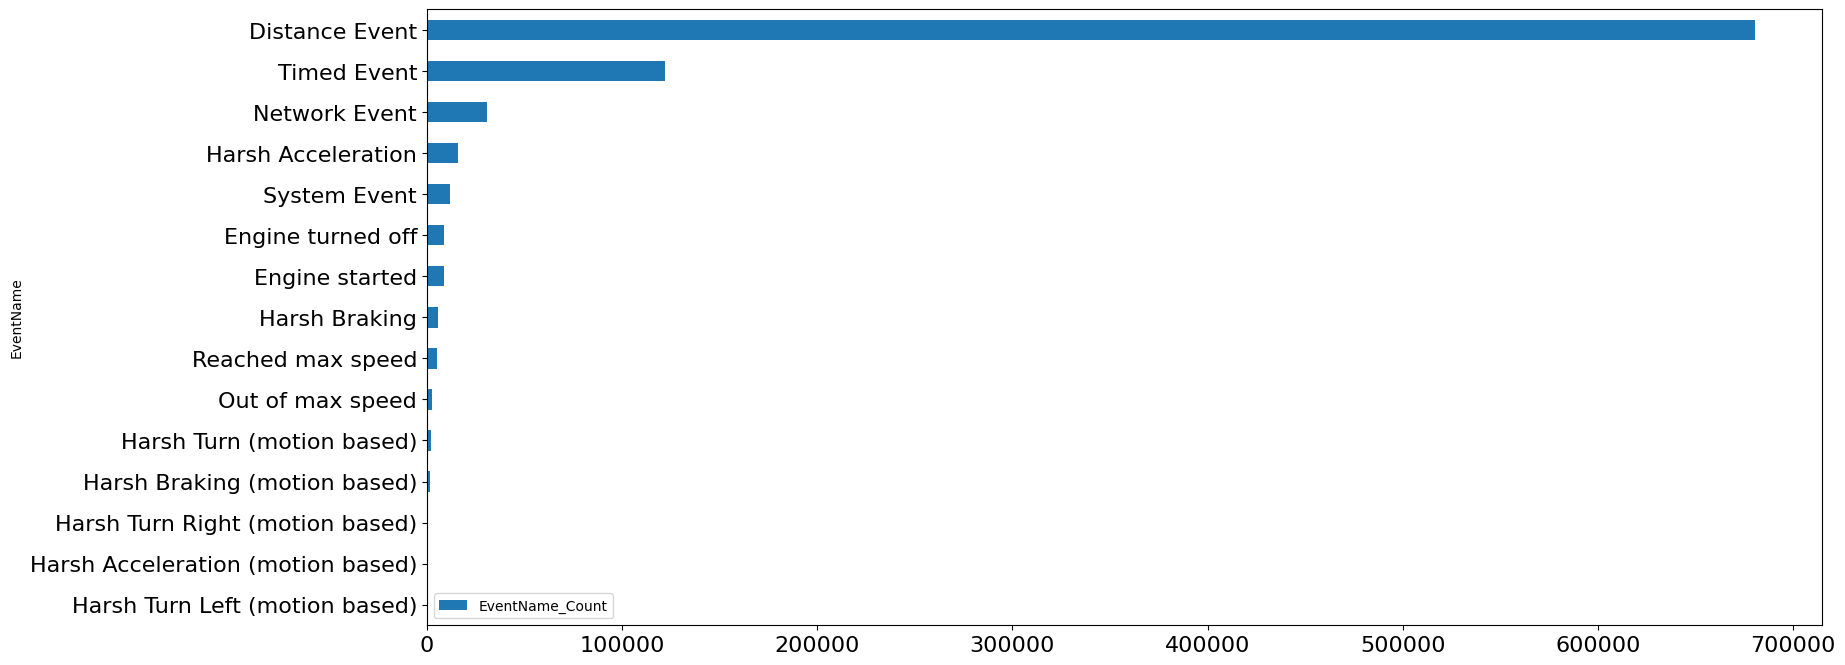

In [10]:
dfReasonHist = dfRaw.groupby(['EventName'])[['EventName']].agg('count').add_suffix('_Count').reset_index().sort_values('EventName_Count',ascending=True)
dfReasonHist.plot.barh('EventName','EventName_Count',figsize=(18,8),fontsize = 16)

In [11]:
events = [event for event in dfRaw.EventName if event not in ['Distance Event','Timed Event','Network Event','System Event']]
newCount = len(dfRaw[dfRaw['EventName'].isin(events)])
print("# of events before removing Distance Event, Timed Event, Network Event: {}, After removing: {}.\nReduction of {:0.2f} events. Current number of events: {}".format(len(dfRaw),newCount,(len(dfRaw) - newCount)/len(dfRaw),newCount))

# of events before removing Distance Event, Timed Event, Network Event: 899611, After removing: 54242.
Reduction of 0.94 events. Current number of events: 54242


In [12]:
RELEVANT_EVENTS = ['Harsh Acceleration', 'Reached max speed', 'Out of max speed',
       'Harsh Braking', 'Harsh Turn (motion based)',
       'Harsh Braking (motion based)', 'Harsh Acceleration (motion based)',
       'Harsh Turn Left (motion based)', 'Harsh Turn Right (motion based)']


def prepData(dfRaw, minRecordsPerSubscriber = 50):
    dfRaw.reset_index(inplace=True)
    print("*** Starting data prep. Length:",len(dfRaw),"***")
  
    
    dfRaw = dfRaw.dropna()
    print("Removed NAs. Length:",len(dfRaw))

    df = dfRaw[dfRaw.EventName.isin(RELEVANT_EVENTS)]
    print("Keeping only events that are relevant for modeling. Length:",len(df))
    
    eventCountPerDriver = df.groupby('DriverId')['DriverId'].agg('count')
    driversWithManyRecords = eventCountPerDriver[eventCountPerDriver > minRecordsPerSubscriber]
    driversWithManyRecords.keys()
    df = df[df.DriverId.isin(driversWithManyRecords.keys())]
    print("Filtering users with too few samples. Length:",len(df))

    print("*** Done. ***")
    return(df)

df = prepData(dfRaw)

df.head()

*** Starting data prep. Length: 899611 ***
Removed NAs. Length: 899611
Keeping only events that are relevant for modeling. Length: 36468
Filtering users with too few samples. Length: 36262
*** Done. ***


,DriverId,EventName,Latitude,Longitude,Speed km/h,ts
41,0,Harsh Acceleration,34.1899,-118.0828,49.0000,2017-11-01 14:30:12.120
112,0,Reached max speed,34.1802,-118.1362,115.0000,2017-11-01 14:35:26.830
130,0,Out of max speed,34.1689,-118.1440,69.0000,2017-11-01 14:36:19.710
149,0,Harsh Braking,34.1591,-118.1414,98.0000,2017-11-01 14:38:01.930
186,0,Reached max speed,34.1375,-118.1473,122.0000,2017-11-01 14:39:59.440


Text(0, 0.5, 'Number of drivers')

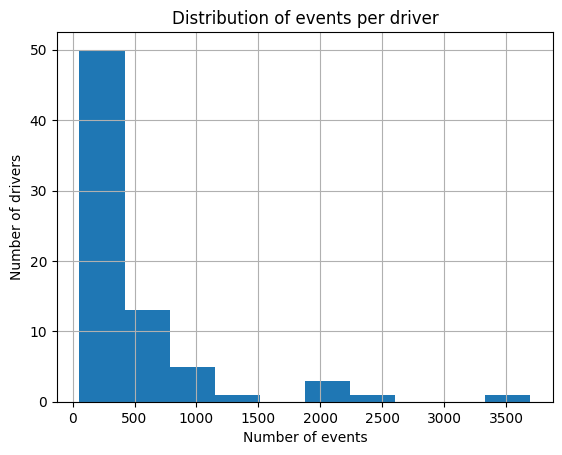

In [13]:
relevantEventsPerSubscriber = df.groupby('DriverId').agg({"EventName":"count"}).sort_values(by='EventName',ascending = False)

eventsHist = relevantEventsPerSubscriber['EventName'].hist()
eventsHist.set_title("Distribution of events per driver")
eventsHist.set_xlabel("Number of events")
eventsHist.set_ylabel("Number of drivers")

Types of events:

<Axes: ylabel='EventName'>

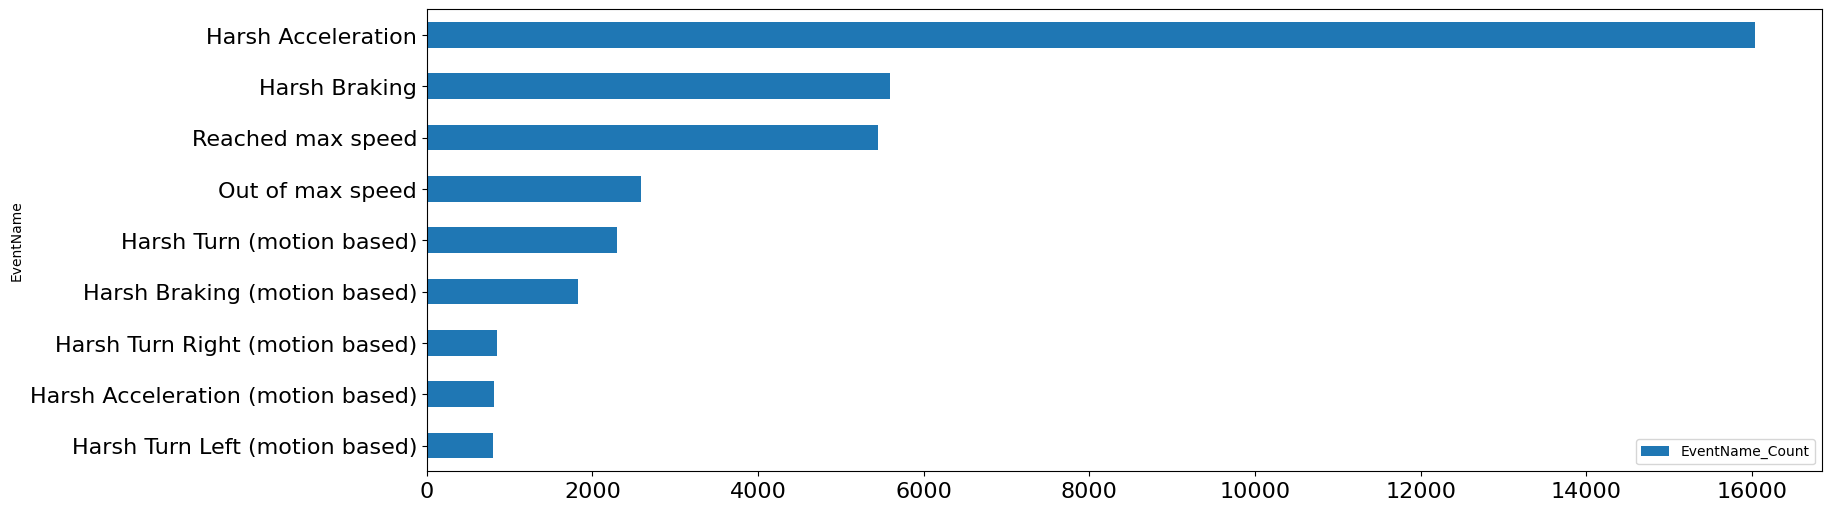

In [14]:
dfReasonHist = df.groupby('EventName')[['EventName']].agg('count').add_suffix('_Count').reset_index().sort_values('EventName_Count',ascending=True)
dfReasonHist.plot.barh('EventName','EventName_Count',figsize=(18,6),fontsize = 16)

In [15]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def total_distance(oneDriver):
    dist = haversine(oneDriver.Longitude.shift(1), oneDriver.Latitude.shift(1),
                 oneDriver.loc[1:, 'Longitude'], oneDriver.loc[1:, 'Latitude'])
    return np.sum(dist)


def calculate_overall_distance_travelled(dfRaw):
    dfDistancePerDriver = dfRaw.groupby('DriverId').apply(total_distance).reset_index(name='Distance')    
    return dfDistancePerDriver

distancePerDriver = calculate_overall_distance_travelled(dfRaw)
distancePerDriver.head(10)

/var/folders/_r/_c6_011j06jgkcs_mg23qs_80000gn/T/ipykernel_96720/4114134117.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dfDistancePerDriver = dfRaw.groupby('DriverId').apply(total_distance).reset_index(name='Distance')


,DriverId,Distance
0,0,3761.7317
1,1,4317.0790
2,2,2509.1244
3,3,491.1896
4,4,1409.9199
5,5,5087.1414
6,6,1271.6811
7,7,2598.3032
8,8,4227.1878
9,9,906.6564


In [16]:

def create_feature_set(df, distancePerDriver):
    dfEventAggByDriver = df.groupby(['DriverId','EventName'])[['EventName']].agg('count').add_suffix('_Count').reset_index()

    dfEventMatrix = dfEventAggByDriver.pivot(index='DriverId',columns='EventName', values='EventName_Count').add_prefix('F_').fillna(0).reset_index()
    dfEventMatrix = dfEventMatrix.merge(distancePerDriver, how = 'inner',on='DriverId')
    dfEventMatrix.set_index('DriverId', inplace=True)
    
    featureCols = [col for col in dfEventMatrix if col.startswith('F_')]
    dfEventMatrix[featureCols] = dfEventMatrix[featureCols].div(dfEventMatrix['Distance'], axis=0)

    dfFeatureSet = dfEventMatrix[featureCols]
    
    return dfFeatureSet

features = create_feature_set(df,distancePerDriver)

In [40]:
features.head()

,Harsh Acceleration,Harsh Braking,Harsh Turning
DriverId,,,
0,0.0003,0.0122,0.0069
1,0.0002,0.0021,0.0000
2,0.0044,0.0120,0.0052
4,0.0000,0.0206,0.0369
5,0.0012,0.0049,0.0177


Since there are two types of systems (motion based and not), we will look at one at a time and not join the two as the values and their proportions might be incomparable. In addition, we'll ignore the inaccurate over speeding event, as noted earlier. 

In [41]:
features = features.rename(columns={'F_Harsh Acceleration (motion based)': "Harsh Acceleration",
                                    'F_Harsh Braking (motion based)': "Harsh Braking",
                                   'F_Harsh Turn (motion based)':"Harsh Turning"},copy =False)

features = features[['Harsh Acceleration','Harsh Braking','Harsh Turning']]

features.head()

,Harsh Acceleration,Harsh Braking,Harsh Turning
DriverId,,,
0,0.0003,0.0122,0.0069
1,0.0002,0.0021,0.0000
2,0.0044,0.0120,0.0052
4,0.0000,0.0206,0.0369
5,0.0012,0.0049,0.0177


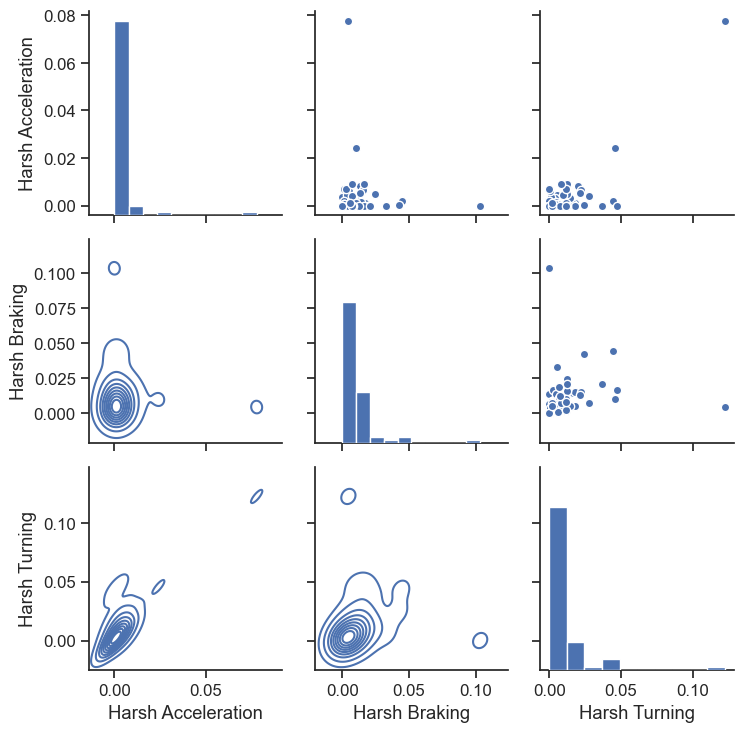

In [19]:
import seaborn as sns
sns.set(style="ticks",font_scale=1.1)
g = sns.PairGrid(features)
g = g.map_upper(plt.scatter, edgecolor="w")
g = g.map_lower(sns.kdeplot)
g = g.map_diag(plt.hist, edgecolor="w")

In [20]:
features.loc[features['Harsh Turning'].idxmax(), ]

Harsh Acceleration   0.0778
Harsh Braking        0.0045
Harsh Turning        0.1226
Name: 51, dtype: float64

In [21]:
import scipy.stats as st

def transform_to_normal(x,min_max_transform = False):
    xt = np.zeros(len(x))
    if np.count_nonzero(x) == 0:
        print("only zero valued values found")
        return x
    
    valueGreaterThanZero = np.where(x<=0,0,1)
    positives = x[valueGreaterThanZero == 1]
    if(len(positives)> 0):
        xt[valueGreaterThanZero == 1],_ = st.boxcox(positives+1)
    if min_max_transform:
        xt = (xt - np.min(xt)) / (np.max(xt)-np.min(xt))
    return xt

transFeatures = features.apply(lambda x: (transform_to_normal(x,min_max_transform = True)))
transFeatures.head()

,Harsh Acceleration,Harsh Braking,Harsh Turning
DriverId,,,
0,0.0386,0.5650,0.3484
1,0.0337,0.1329,0.0000
2,0.4766,0.5569,0.2748
4,0.0000,0.7523,0.8953
5,0.1601,0.2851,0.6641


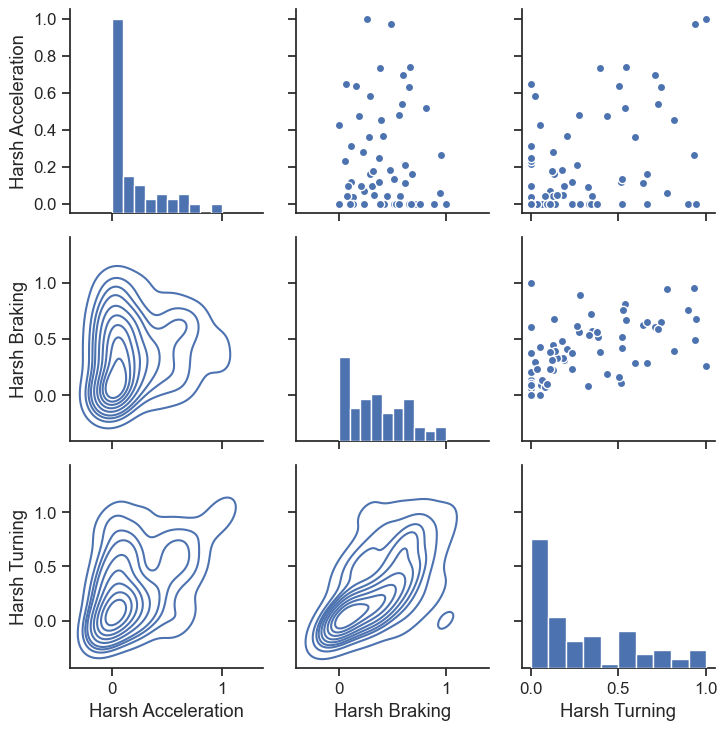

In [22]:
g = sns.PairGrid(transFeatures)
g = g.map_upper(plt.scatter, edgecolor="w")
g = g.map_lower(sns.kdeplot)
g = g.map_diag(plt.hist, edgecolor="w")

In [23]:

import seaborn as sns
sns.set(style="ticks")

def replace_outliers_with_limit(x, stdFactor = 2.5, normalize = False):
    print(x.name)
    x = x.values
    xt = np.zeros(len(x))
    if np.count_nonzero(x) == 0:
        print("only zero valued values found")
        return x
    
    xt = transform_to_normal(x)

    xMean, xStd = np.mean(xt), np.std(xt)
    outliers = np.where(xt > xMean + stdFactor*xStd)[0]
    inliers = np.where(xt <= xMean + stdFactor*xStd)[0]
    if len(outliers) > 0:
        print("found outlier with factor: "+str(stdFactor)+" : "+str(outliers))
        xinline = x[inliers]
        maxInRange = np.max(xinline)
        print("replacing outliers {} with max={}".format(outliers,maxInRange))
        vals = x.copy()
        vals[outliers] = maxInRange
        x= pd.Series(vals)
    else:
        print("No outliers found")
    if normalize:
        x = (x - np.min(x)) / (np.max(x)-np.min(x))
    return x

cleanFeatures = features.apply(lambda x: (replace_outliers_with_limit(x)))
cleanFeatures.head(6)


Harsh Acceleration
found outlier with factor: 2.5 : [15 44]
replacing outliers [15 44] with max=0.009031595984492276
Harsh Braking
No outliers found
Harsh Turning
No outliers found


,Harsh Acceleration,Harsh Braking,Harsh Turning
0,0.0003,0.0122,0.0069
1,0.0002,0.0021,0.0000
2,0.0044,0.0120,0.0052
3,0.0000,0.0206,0.0369
4,0.0012,0.0049,0.0177
5,0.0008,0.0142,0.0165


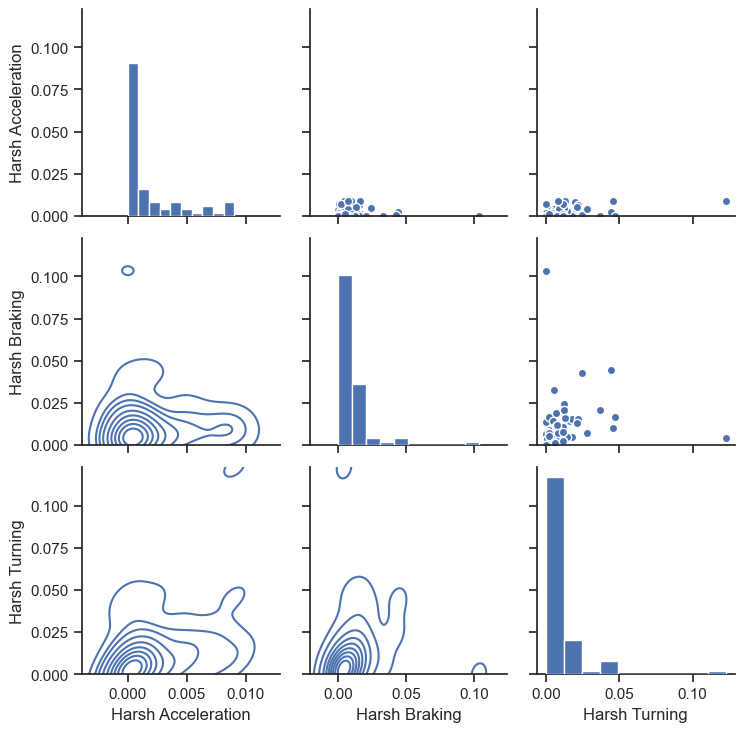

In [24]:
g = sns.PairGrid(cleanFeatures)
g = g.map_upper(plt.scatter, edgecolor="w")
g = g.map_lower(sns.kdeplot)
g = g.map_diag(plt.hist, edgecolor="w")
g = g.set(ylim=((cleanFeatures.min().min()),(cleanFeatures.max().max())))

<Axes: >

<Figure size 640x480 with 0 Axes>

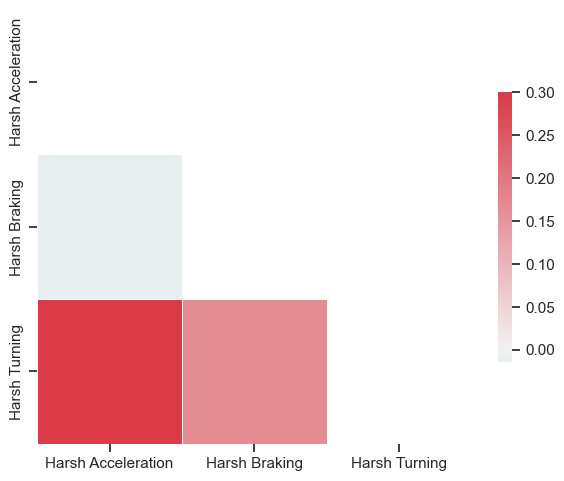

In [25]:
corr = cleanFeatures.corr()


mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig = plt.figure()

f, ax = plt.subplots(figsize=(7, 7))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [26]:

minPerFeature = cleanFeatures.min()
maxPerFeature = cleanFeatures.max()

print("Min and Max values per column before normalization")
for col in range(0,len(cleanFeatures.columns)):
    print("{} range:[{},{}]".format(cleanFeatures.columns[col],minPerFeature[col],maxPerFeature[col]))

normalizedFeatures = (cleanFeatures-cleanFeatures.min())/(cleanFeatures.max()-cleanFeatures.min())
normalizedFeatures.head()


transFeaturesScaled = (transFeatures - transFeatures.mean())/transFeatures.std()
print("")
print("Mean and STD before standardization")
for col in range(0,len(transFeatures.columns)):
    print("{} range:[{},{}]".format(transFeatures.columns[col],transFeatures.mean()[col],transFeatures.std()[col]))


normalizedFeatures.head()

Min and Max values per column before normalization
Harsh Acceleration range:[0.0,0.009031595984492276]
Harsh Braking range:[0.0,0.1034054852268694]
Harsh Turning range:[0.0,0.12259498755008964]

Mean and STD before standardization
Harsh Acceleration range:[0.18775905275918472,0.2558842002570995]
Harsh Braking range:[0.35563515454391814,0.27605609117798774]
Harsh Turning range:[0.2865774165948339,0.2988857705838427]


/var/folders/_r/_c6_011j06jgkcs_mg23qs_80000gn/T/ipykernel_96720/3673336057.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("{} range:[{},{}]".format(cleanFeatures.columns[col],minPerFeature[col],maxPerFeature[col]))
/var/folders/_r/_c6_011j06jgkcs_mg23qs_80000gn/T/ipykernel_96720/3673336057.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("{} range:[{},{}]".format(transFeatures.columns[col],transFeatures.mean()[col],transFeatures.std()[col]))


,Harsh Acceleration,Harsh Braking,Harsh Turning
0,0.0294,0.1183,0.0564
1,0.0256,0.0202,0.0000
2,0.4854,0.1156,0.0423
3,0.0000,0.1989,0.3008
4,0.1306,0.0475,0.1443


In [27]:

from sklearn.neighbors import LocalOutlierFactor

X = transFeaturesScaled.values

clf = LocalOutlierFactor(n_neighbors=5)
isOutlier = clf.fit_predict(X)

/Users/danieldas/miniconda3/envs/hursun2024sih/lib/python3.9/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


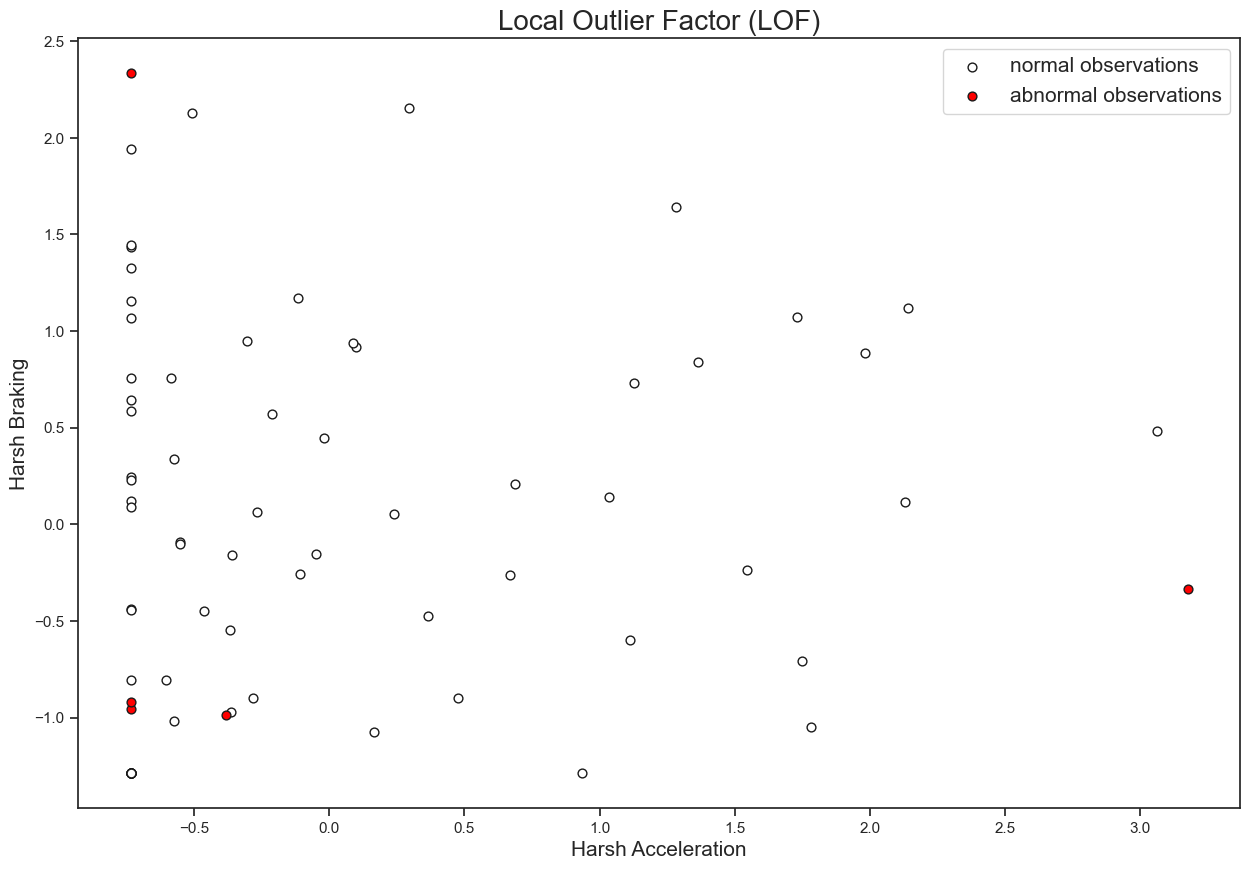

In [28]:
plt.title("Local Outlier Factor (LOF)",fontsize=20)


a = plt.scatter(X[isOutlier==1, 0], X[isOutlier==1, 1], c='white',
                edgecolor='k', s=40)
b = plt.scatter(X[isOutlier==-1, 0], X[isOutlier==-1, 1], c='red',
                edgecolor='k', s=40)
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.xlabel(normalizedFeatures.columns[0],fontsize = 15)
plt.ylabel(normalizedFeatures.columns[1],fontsize = 15)

plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper right",prop={'size': 15},frameon = True)
plt.show()

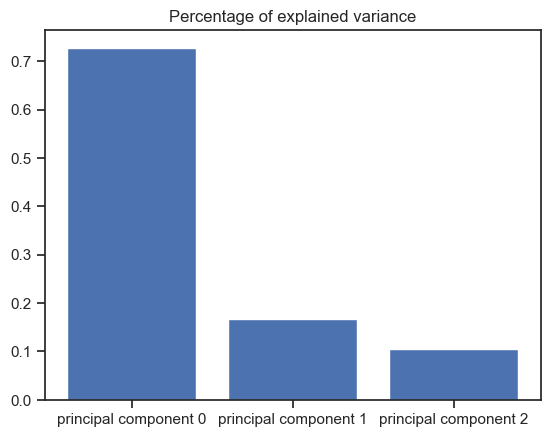

Pricipal components explained variance ratio: [0.7275472  0.16648689 0.10596592].


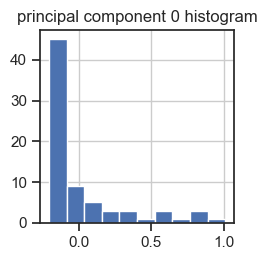

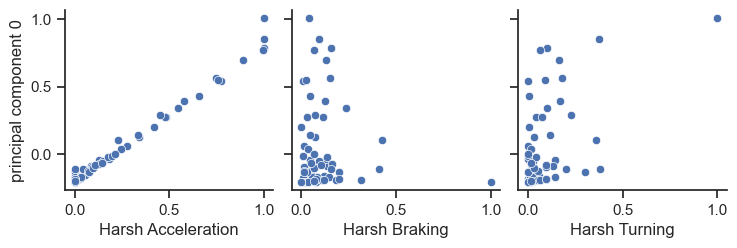

In [29]:

from sklearn.decomposition import PCA

pca = PCA(n_components=3)

principalComponents = pca.fit_transform(normalizedFeatures)
column_names = ['principal component {}'.format(i) for i in range(normalizedFeatures.shape[1])]


plt.bar(x = column_names,height = pca.explained_variance_ratio_)
plt.title("Percentage of explained variance")
plt.show()

print("Pricipal components explained variance ratio: {}.".format(pca.explained_variance_ratio_))


principalDf = pd.DataFrame(data = principalComponents
             , columns = column_names)

import matplotlib.pyplot as plt
df = normalizedFeatures
fig = plt.gcf()
fig.set_size_inches(15,10)


pcAndOriginal = pd.concat([principalDf.iloc[:,0].reset_index(drop=True), normalizedFeatures], axis=1)
sns.set(style="ticks")
histplot = pcAndOriginal['principal component 0'].hist(figsize = (2.5,2.5))
histplot.set_title("principal component 0 histogram")
sns.pairplot(pcAndOriginal,y_vars=['principal component 0'],
                  x_vars=['Harsh Acceleration', 'Harsh Braking', 'Harsh Turning'])


#### Extract statistics from the fitted distributions

In [30]:
import scipy.stats as st


def fit_distribution_params(series):
    print("Extracting distribution parameters for feature: " + series.name + " (" + str(len(series)) + ' values)')
    xPositive = series[series>0]
  
    probs = np.zeros(len(series))
    if(len(xPositive)>0):
        params = st.expon.fit(xPositive)
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]
        return arg, loc, scale

def calculate_score_for_series(x, fittedParams,verbose = False):
    
    print("Calculating scores for feature: "+ x.name)
    xPositive = x[x>0]
  
    probs = np.zeros(len(x))
    if(len(xPositive)>0):
        arg = fittedParams[x.name]['arg']
        loc = fittedParams[x.name]['loc']
        scale = fittedParams[x.name]['scale']
        probs[x>0] = st.expon.cdf(xPositive, loc=loc, scale=scale, *arg)
        if verbose:
            probs_df = pd.DataFrame({'Event value':x.values.tolist(),'Event probability':probs},index = None)
            probs_df = probs_df.sort_values(by = 'Event value')
            print(probs_df)
    return probs


fittedParams = {}
for col in normalizedFeatures.columns:
    arg,loc,scale = fit_distribution_params(normalizedFeatures[col])
    fittedParams[col] = {}
    fittedParams[col]['arg'] = arg
    fittedParams[col]['loc'] = loc
    fittedParams[col]['scale'] = scale
import json
print('Fitted parameters:')
print(json.dumps(fittedParams, indent=2))


perFeatureScores = normalizedFeatures.apply(calculate_score_for_series,args=(fittedParams,False),axis=0).add_suffix("_CDF")

perFeatureScores.head()

Extracting distribution parameters for feature: Harsh Acceleration (74 values)
Extracting distribution parameters for feature: Harsh Braking (74 values)
Extracting distribution parameters for feature: Harsh Turning (74 values)
Fitted parameters:
{
  "Harsh Acceleration": {
    "arg": [],
    "loc": 0.025647527148672286,
    "scale": 0.3036451443479721
  },
  "Harsh Braking": {
    "arg": [],
    "loc": 0.008563763159666797,
    "scale": 0.10093946454658832
  },
  "Harsh Turning": {
    "arg": [],
    "loc": 0.0037259899163476383,
    "scale": 0.09977908243787285
  }
}
Calculating scores for feature: Harsh Acceleration
Calculating scores for feature: Harsh Braking
Calculating scores for feature: Harsh Turning


,Harsh Acceleration_CDF,Harsh Braking_CDF,Harsh Turning_CDF
0,0.0124,0.6627,0.4100
1,0.0000,0.1085,0.0000
2,0.7800,0.6538,0.3204
3,0.0000,0.8483,0.9491
4,0.2922,0.3202,0.7556


Harsh Acceleration
sse: 88.82176421244914
Harsh Braking
sse: 24.716350294530713
Harsh Turning
sse: 98.4804990432469


Text(0, 0.5, 'Number of drivers')

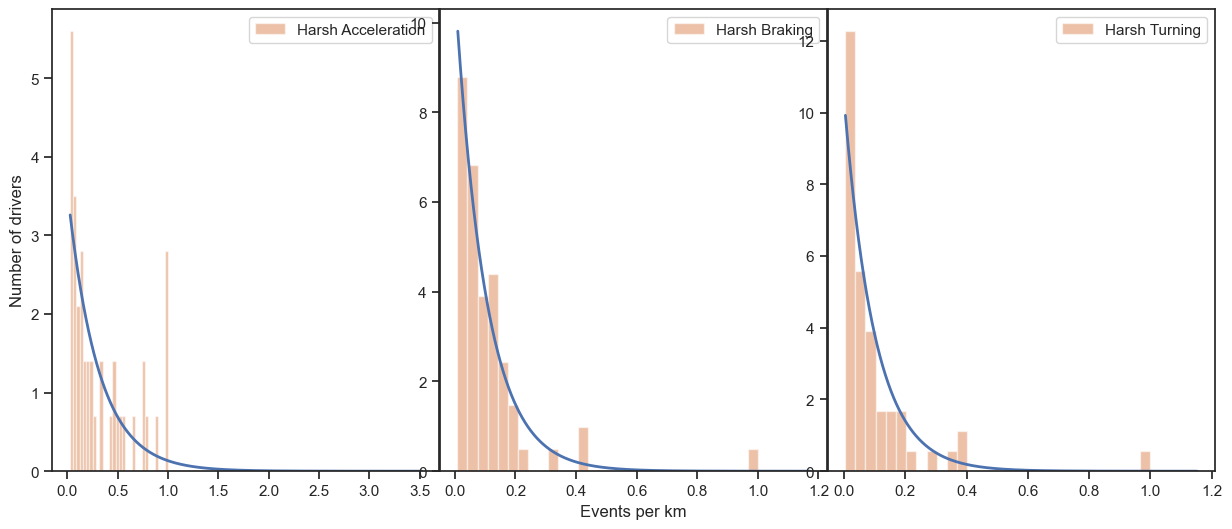

In [31]:

import matplotlib.pyplot as plt
import scipy.stats as st

DIST = st.expon

def create_pdf(dist, params, size=10000):

    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99999, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99999, loc=loc, scale=scale)
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

fig, axs = plt.subplots(1,3, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
i=0
for col in normalizedFeatures:
    print(col)
    feature = normalizedFeatures[col]
    x = feature.values[feature.values > 0] 
   
    params = DIST.fit(x)

    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
   

    pdfForPlot = create_pdf(DIST,params)
    pdfForPlot.plot(lw=2, label='PDF',ax=axs[i])
    

    feature[feature.values >0].plot(kind='hist', bins=30, density=True, alpha=0.5, label=feature.name, legend=True,ax=axs[i])
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')

    yhist, xhist = np.histogram(x, bins=60, density=True)
    xhist = (xhist + np.roll(xhist, -1))[:-1] / 2.0
    histPdf = DIST.pdf(xhist, loc=loc, scale=scale, *arg)
    sse = np.sum(np.power(yhist - histPdf, 2.0))
    print("sse:",sse)
    i+=1
axs[1].set_xlabel('Events per km')
axs[0].set_ylabel('Number of drivers')

    

In [32]:
def calculate_joint_score(perFeatureScores):
    driverScores = perFeatureScores
    featureCols = [col for col in driverScores if col.startswith('Harsh')]
    driverScores['metric'] = (driverScores[featureCols].sum(axis = 1) / 3.0)
    driverScores = driverScores.sort_values('metric')
    driverScores['rank'] = (driverScores.metric.rank(method="min")-1)/((len(perFeatureScores)-1)*1.0)
    return driverScores

driverScores = calculate_joint_score(perFeatureScores)

In [35]:
from sklearn.linear_model import LinearRegression

def get_linear_model(perFeatureScores):
    driverScores = calculate_joint_score(perFeatureScores)
    reg = LinearRegression()
    x = driverScores['metric'].values.reshape(-1, 1)
    y = driverScores['rank'].values.reshape(-1, 1)
    reg.fit(x,y)
    return reg
    

def get_rank(regModel, metric):
   
    metric = np.array(metric).reshape(-1, 1)  
    rank = regModel.predict(metric)
    rank = np.where(rank > 1, 1, rank) 
    rank = np.where(rank < 0, 0, rank) 
    return rank[0]  
    
regModel = get_linear_model(perFeatureScores)
sampleRank = get_rank(regModel,0.5)
sampleRank

array([0.69451077])

In [36]:

driverScores.head(10)

,Harsh Acceleration_CDF,Harsh Braking_CDF,Harsh Turning_CDF,metric,rank
32,0.0000,0.0000,0.0000,0.0000,0.0000
29,0.0000,0.0000,0.0000,0.0000,0.0000
70,0.0000,0.0000,0.0000,0.0000,0.0000
68,0.0000,0.0000,0.0000,0.0000,0.0000
67,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.0000
27,0.0000,0.0000,0.0000,0.0000,0.0000
25,0.0000,0.0000,0.0000,0.0000,0.0000
51,0.0000,0.0000,0.0000,0.0000,0.0000
20,0.0000,0.0000,0.0000,0.0000,0.0000


In [37]:

driverScores.tail(10)

,Harsh Acceleration_CDF,Harsh Braking_CDF,Harsh Turning_CDF,metric,rank
39,0.0597,0.9814,0.8592,0.6334,0.8767
59,0.7542,0.4614,0.8925,0.7027,0.8904
44,0.9596,0.2901,1.0000,0.7499,0.9041
42,0.8186,0.8951,0.6245,0.7794,0.9178
72,0.8373,0.6875,0.8155,0.7801,0.9315
48,0.9596,0.7662,0.6328,0.7862,0.9452
7,0.9421,0.7009,0.7955,0.8128,0.9589
37,0.4886,0.9845,0.9724,0.8152,0.9726
16,0.9074,0.7545,0.8277,0.8299,0.9863
15,0.9596,0.5765,0.9756,0.8372,1.0000


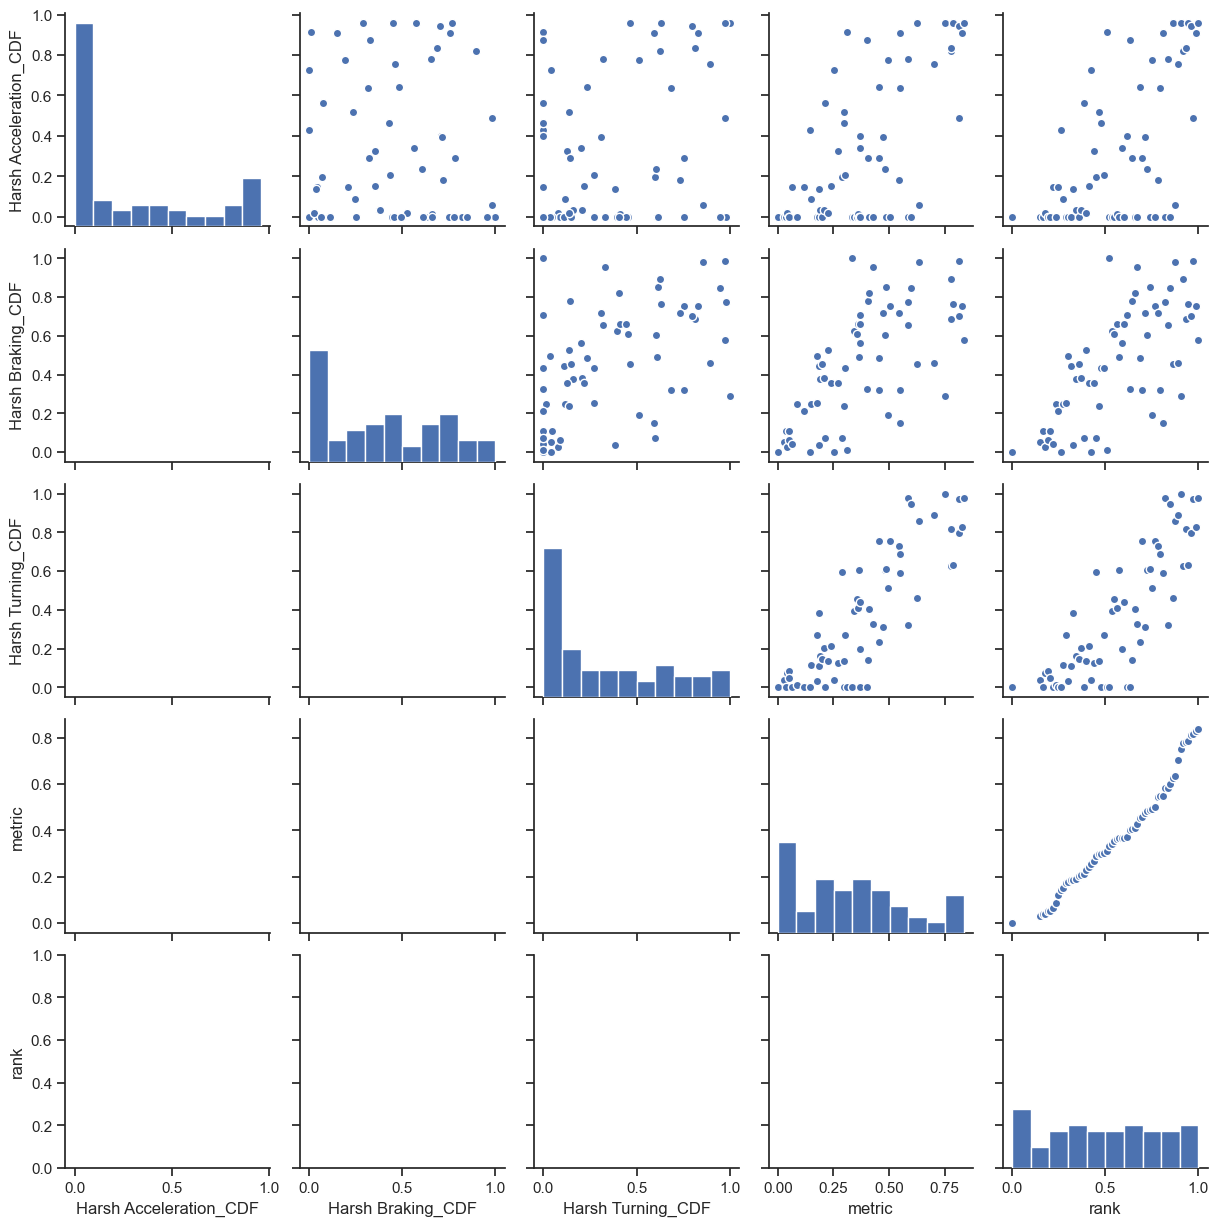

In [38]:
import seaborn as sns
sns.set(style="ticks")
g = sns.PairGrid(driverScores)
g = g.map_upper(plt.scatter, edgecolor="w")
g = g.map_diag(plt.hist, edgecolor="w")

In [39]:
safeDriver = [{'Harsh Acceleration':0.005,
                       'Harsh Braking':0.005,
                       'Harsh Turning':0.005}]

riskyDriver = [{'Harsh Acceleration':0.2,
                       'Harsh Braking':0.16,
                       'Harsh Turning':0.28}]

safeDriverDf = pd.DataFrame(safeDriver,index = None)
riskyDriverDf = pd.DataFrame(riskyDriver,index = None)

print('****** Estimated safety scores ******')
def get_score_one_driver(driverDf,fittedParams,minPerFeature,maxPerFeature):

    normalized = (driverDf - minPerFeature) / (maxPerFeature - minPerFeature)
    scoreDF = pd.DataFrame()
    for col in normalized:
        scoreDF[col] = calculate_score_for_series(normalized[col],fittedParams,True)
    scoreDF = calculate_joint_score(scoreDF)
    return scoreDF


safeDriverWithMetric = get_score_one_driver(safeDriverDf, fittedParams,minPerFeature,maxPerFeature)
riskyDriverWithMetric = get_score_one_driver(riskyDriverDf, fittedParams,minPerFeature,maxPerFeature)

safeDriverMetric = safeDriverWithMetric['metric'].values[0]
riskyDriverMetric = riskyDriverWithMetric['metric'].values[0]


print('------')
print("Rank for safe driver = {}".format(get_rank(regModel,safeDriverMetric)))
print("Metric for safe driver = {}".format(safeDriverMetric))
print('------')
print("Rank for risky driver = {}".format(get_rank(regModel,riskyDriverMetric)))
print("Metric for risky driver = {}".format(riskyDriverMetric))


****** Estimated safety scores ******
Calculating scores for feature: Harsh Acceleration
   Event value  Event probability
0       0.5536             0.8243
Calculating scores for feature: Harsh Braking
   Event value  Event probability
0       0.0484             0.3258
Calculating scores for feature: Harsh Turning
   Event value  Event probability
0       0.0408             0.3102
Calculating scores for feature: Harsh Acceleration
   Event value  Event probability
0      22.1445             1.0000
Calculating scores for feature: Harsh Braking
   Event value  Event probability
0       1.5473             1.0000
Calculating scores for feature: Harsh Turning
   Event value  Event probability
0       2.2839             1.0000
------
Rank for safe driver = [0.67858887]
Metric for safe driver = 0.4867579625382503
------
Rank for risky driver = [1.]
Metric for risky driver = 0.9999999200873383
